In [107]:
import numpy  as np
import os
import matplotlib.pyplot as plt
import matplotlib
import pydicom
import random
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

Using TensorFlow backend.


In [20]:
height, width = 10, 20
matplotlib.rcParams['figure.figsize'] = [width, height]

In [73]:
path = '/home/andy/Projects/RSNA_Pneumonia/Data/rsna-pneumonia-detection-challenge'
os.listdir(path)

['stage_2_train_images',
 'stage_2_detailed_class_info.csv',
 'stage_2_test_images',
 'stage_2_sample_submission.csv',
 'stage_2_train_labels.csv']

In [74]:
detailed_class_info = pd.read_csv(os.path.join(path, 'stage_2_detailed_class_info.csv'))
sample_submission = pd.read_csv(os.path.join(path, 'stage_2_sample_submission.csv'))
train_labels = pd.read_csv(os.path.join(path, 'stage_2_train_labels.csv'))

In [75]:
detailed_class_info.sample(3)

,patientId,class
21056,bf1103d5-18c7-4578-9ad2-a7e279d9a6a3,Lung Opacity
2369,317ee2f4-c102-4558-b6c4-3a613f01bf84,No Lung Opacity / Not Normal
21561,c3ed4cdc-183a-4b8f-a51f-d915d912abab,Lung Opacity


In [76]:
sample_submission.sample(3)


,patientId,PredictionString
37,0076e39f-5189-4751-8274-da6df4d5e429,0.5 0 0 100 100
1569,204d03dd-3faf-4c16-a432-a139493c2928,0.5 0 0 100 100
38,0076e68b-90cf-45da-a839-e67d3131182b,0.5 0 0 100 100


## Studing the train labels

In [77]:
train_labels.sample(5)

,patientId,x,y,width,height,Target
1174,0ebc8268-df3d-45d8-8ee7-b34880c62830,225.0,536.0,225.0,133.0,1
7758,598a9d0e-f27d-44de-beb1-3929a674be25,NaN,NaN,NaN,NaN,0
5962,4b1bd2e0-bbc1-4cf4-8f35-565c1ab1385b,NaN,NaN,NaN,NaN,0
17317,a5bce1d8-51c4-4904-9119-b902010752f7,NaN,NaN,NaN,NaN,0
16513,9fa14682-ad76-4df6-80a6-aa623e59ff4c,NaN,NaN,NaN,NaN,0


In [78]:
train_labels.fillna(0, inplace=True)

In [79]:
train_labels['path'] = train_labels.patientId.apply(lambda x: os.path.join(path, 'stage_2_train_images', x + '.dcm'))
map_detailed = detailed_class_info.groupby('patientId').apply(lambda x: x['class'].unique()[0])
train_labels['Class'] = train_labels.patientId.map(map_detailed)
train_labels['detailed_class'] = train_labels['Class']
train_labels['Class'] = train_labels.Class.apply(lambda x: x.split('/'))
train_labels['Class'] = train_labels.Class.apply(lambda x: [s.strip() for s in x])
train_labels.head()

,patientId,x,y,width,height,Target,path,Class,detailed_class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,"[No Lung Opacity, Not Normal]",No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,"[No Lung Opacity, Not Normal]",No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,"[No Lung Opacity, Not Normal]",No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Normal],Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Lung Opacity],Lung Opacity


In [80]:
positive_samples = train_labels.loc[train_labels.Target == 1].reset_index(drop=True)
negative_samples = train_labels.loc[train_labels.Target == 0].reset_index(drop=True)

In [81]:
samples_positive_images = []
samples_negative_images = []

for i in range(4):
    sample_dicom_pos = pydicom.read_file(positive_samples.path[random.randint(0, positive_samples.shape[0])])
    sample_dicom_neg = pydicom.read_file(negative_samples.path[random.randint(0, negative_samples.shape[0])])
    samples_positive_images.append(sample_dicom_pos.pixel_array)
    samples_negative_images.append(sample_dicom_neg.pixel_array)
samples_positive_images = np.array(samples_positive_images)
samples_negative_images = np.array(samples_negative_images)

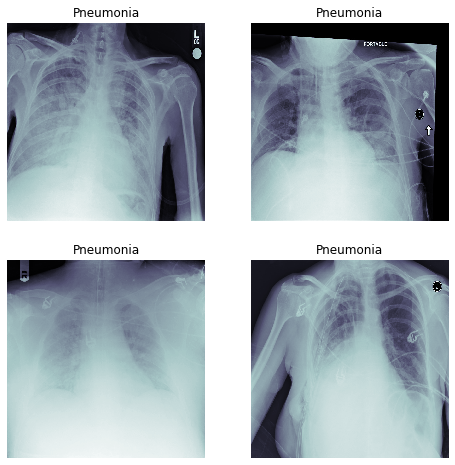

In [82]:
fig, m_axs = plt.subplots(2, 2, figsize = (8, 8))
for (img, c_ax) in zip(samples_positive_images, m_axs.flatten()):
    c_ax.imshow(img, cmap = 'bone')
    c_ax.set_title('Pneumonia')
    c_ax.axis('off')

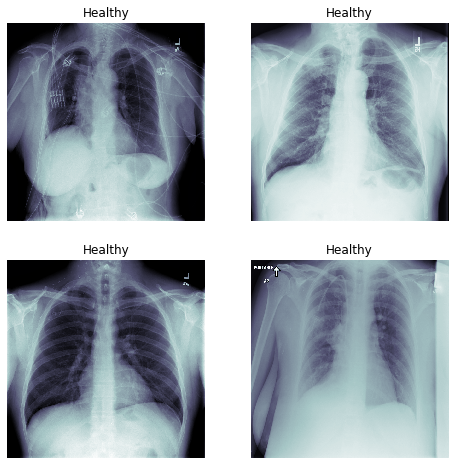

In [83]:
fig, m_axs = plt.subplots(2, 2, figsize = (8, 8))
for (img, c_ax) in zip(samples_negative_images , m_axs.flatten()):
    c_ax.imshow(img, cmap = 'bone')
    c_ax.set_title('Healthy')
    c_ax.axis('off')

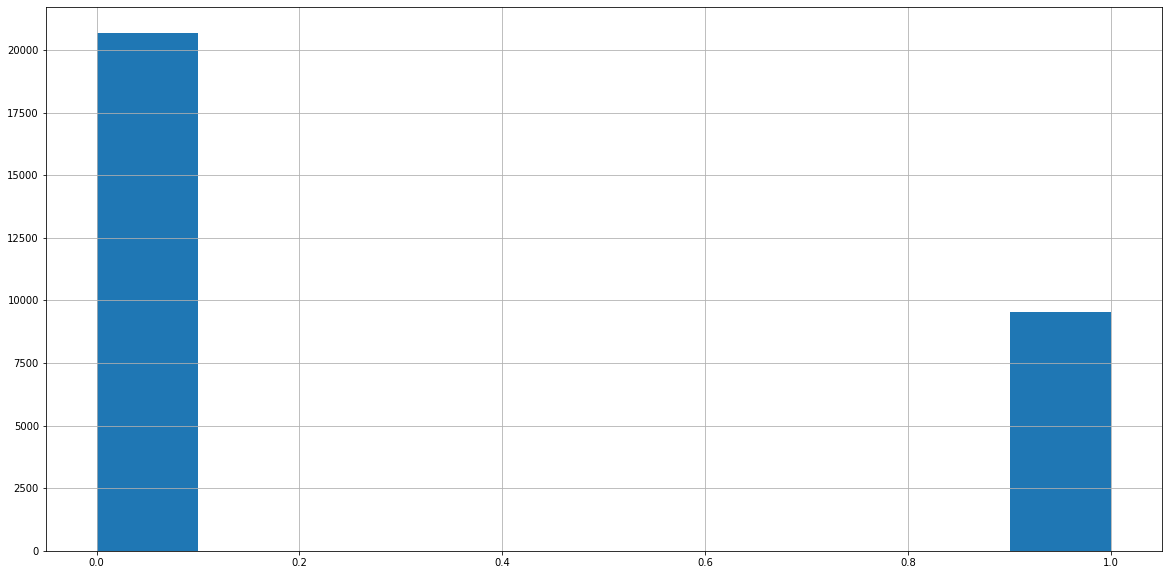

In [84]:
train_labels.Target.hist()

In [85]:
def data_dict(df):

    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    df_dict = {}
    for n, row in df.iterrows():

        p_id = row['patientId']
        if p_id not in df_dict:
            df_dict[p_id] = {
                            'dicom': os.path.join(path, 'stage_2_train_images', '{}'.format(p_id) + '.dcm'),
                            'label': row['Target'],
                            'boxes': [],
                            'class': row['Class']
                            }

        if df_dict[p_id]['label'] == 1:
            df_dict[p_id]['boxes'].append(extract_box(row))

    return df_dict
dict_df = data_dict(train_labels)

In [86]:
sample_patient_multi = []

for p_id in dict_df.keys():
    if len(dict_df[p_id]['boxes']) > 1:
        sample_patient_multi.append(p_id)

print("Number of patients have multiple bounding boxes: ", len(sample_patient_multi))

Number of patients have multiple bounding boxes:  3398


In [87]:
def images_bounding_boxes(patient_ids=None):

    fig, axes = plt.subplots(2, 3, figsize=(10, 10))
    for ax in axes.flatten():

        while True:
        
            p_id = random.choice(patient_ids)
        
            if dict_df[p_id]['label'] != 0:
                break

        dicom = pydicom.read_file(dict_df[p_id]['dicom'])
        image = dicom.pixel_array

        for box in dict_df[p_id]['boxes']:

            ax.imshow(image, cmap='bone')

            line_values = [255, 0, 0]
            box_values = [int(b) for b in box]
        
            y1, x1, height, width = box
            bounding_box = matplotlib.patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(bounding_box)

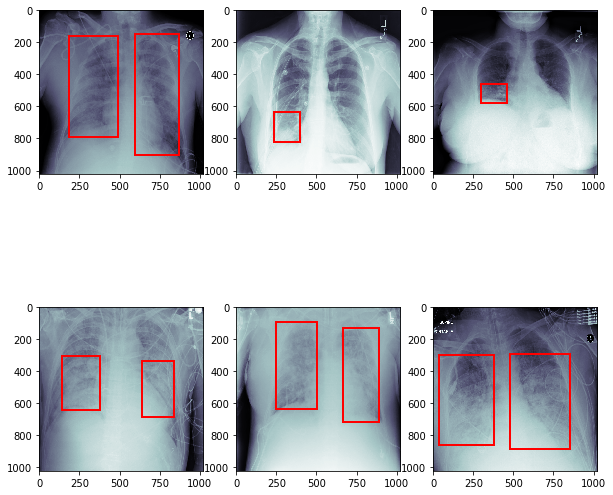

In [88]:
images_bounding_boxes(train_labels.patientId)

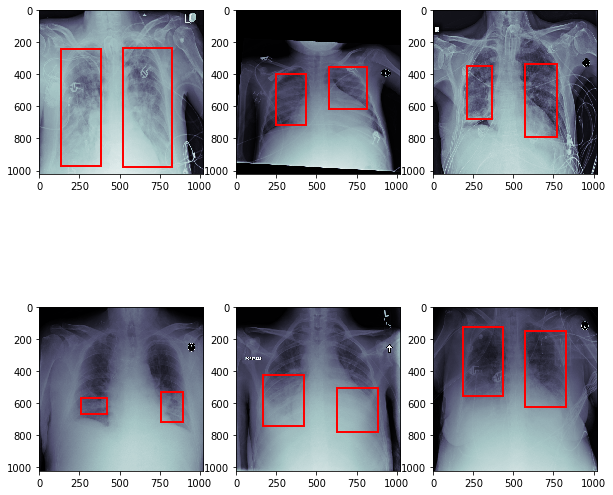

In [89]:
images_bounding_boxes(sample_patient_multi)

In [90]:
opacity_image = pydicom.read_file(dict_df[random.choice(positive_samples.patientId)]['dicom']).pixel_array
no_opacity_image = pydicom.read_file(dict_df[random.choice([p_id for p_id in list(dict_df) if 'No Lung Opacity' in dict_df[p_id]['class']])]['dicom']).pixel_array
not_normal_image = pydicom.read_file(dict_df[random.choice([p_id for p_id in list(dict_df) if 'Not Normal' in dict_df[p_id]['class']])]['dicom']).pixel_array

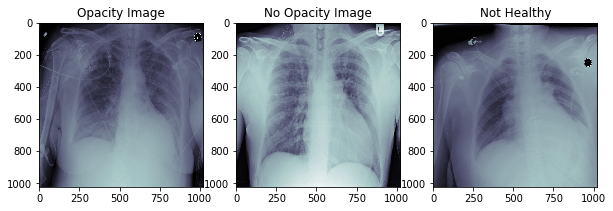

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10), squeeze=False)
axes[0][0].imshow(opacity_image, cmap='bone')
axes[0][0].title.set_text('Opacity Image')
axes[0][1].imshow(no_opacity_image, cmap='bone')
axes[0][1].title.set_text('No Opacity Image')
axes[0][2].imshow(not_normal_image, cmap='bone')
axes[0][2].title.set_text('Not Healthy')

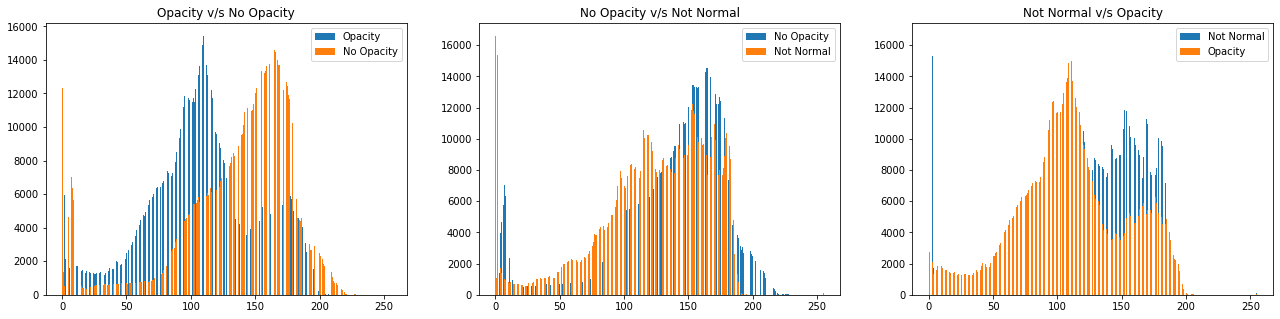

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(22, 5), squeeze=False)
axes[0][0].hist(opacity_image.ravel(), bins=500, label='Opacity')
axes[0][0].hist(no_opacity_image.ravel(), bins=500, label='No Opacity')
axes[0][0].legend(prop={'size': 10})
axes[0][0].title.set_text('Opacity v/s No Opacity')

axes[0][1].hist(no_opacity_image.ravel(), bins=500, label='No Opacity')
axes[0][1].hist(not_normal_image.ravel(), bins=500, label='Not Normal')
axes[0][1].legend(prop={'size': 10})
axes[0][1].title.set_text('No Opacity v/s Not Normal')

axes[0][2].hist(not_normal_image.ravel(), bins=500, label='Not Normal')
axes[0][2].hist(opacity_image.ravel(), bins=500, label='Opacity')
axes[0][2].legend(prop={'size': 10})
axes[0][2].title.set_text('Not Normal v/s Opacity')

In [93]:
train_labels.dropna(inplace=True)
train_labels

,patientId,x,y,width,height,Target,path,Class,detailed_class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,"[No Lung Opacity, Not Normal]",No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,"[No Lung Opacity, Not Normal]",No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,"[No Lung Opacity, Not Normal]",No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Normal],Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Lung Opacity],Lung Opacity
...,...,...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Lung Opacity],Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Normal],Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Normal],Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Lung Opacity],Lung Opacity


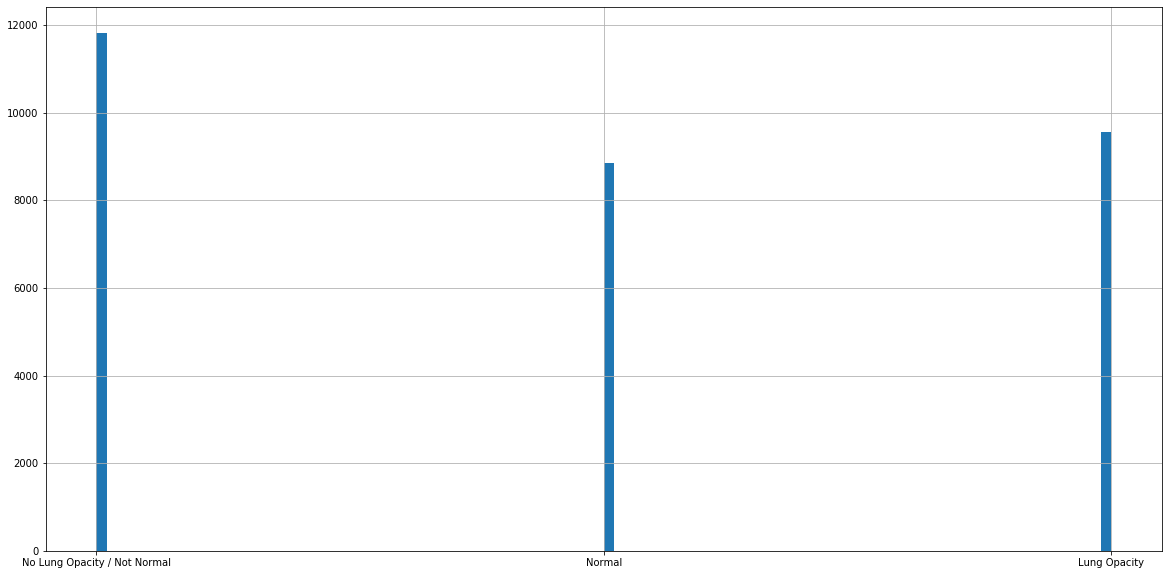

In [94]:
_ = train_labels.detailed_class.hist(align='mid', bins=100)

In [95]:
vc_class = train_labels.detailed_class.value_counts()
one_third_train_size = vc_class['Normal']
vc_class

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: detailed_class, dtype: int64

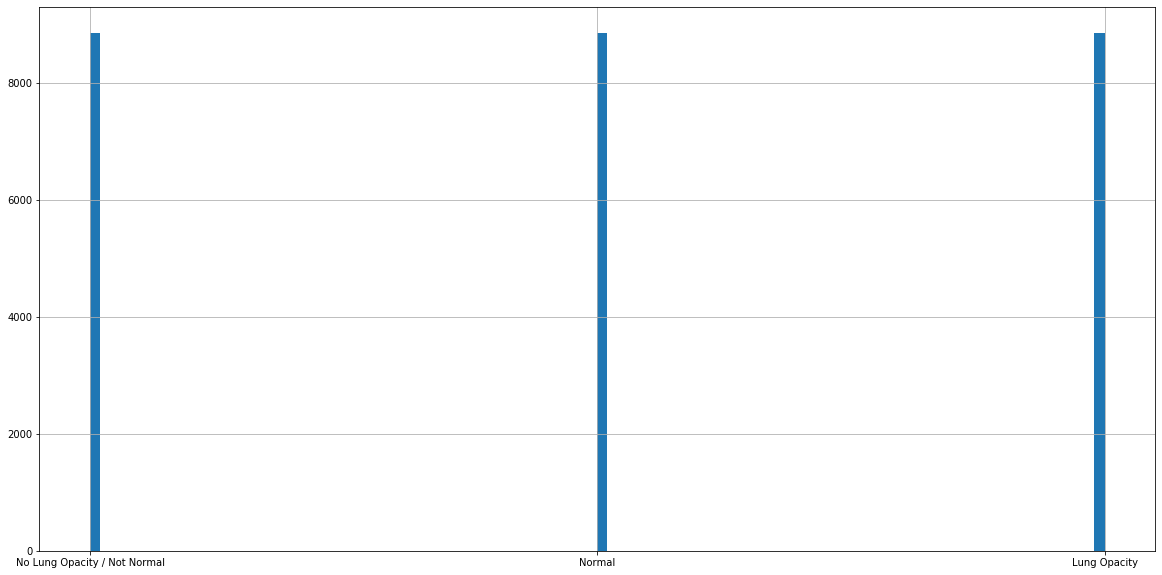

In [98]:
df = pd.concat([
    train_labels.loc[train_labels.detailed_class == 'Normal'],
    train_labels.loc[train_labels.detailed_class == 'Lung Opacity'].sample(one_third_train_size),
    train_labels.loc[train_labels.detailed_class == 'No Lung Opacity / Not Normal'].sample(one_third_train_size)
    ], axis=0)
df = train_df.sample(frac=1)
_ = df.detailed_class.hist(align='mid', bins=100)

In [99]:
df

,patientId,x,y,width,height,Target,path,Class,detailed_class
14670,908c8680-2a19-4975-bd5c-8184f2c4e96c,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,"[No Lung Opacity, Not Normal]",No Lung Opacity / Not Normal
27343,f2dc6cb2-9883-46d1-ab94-ffb54cb9ea36,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Normal],Normal
24358,dae0dd94-d374-40d0-a12b-a8feee49f3a2,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Normal],Normal
6016,4b7e6809-b113-4019-9230-15745042554d,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,"[No Lung Opacity, Not Normal]",No Lung Opacity / Not Normal
24156,d92e2550-e573-4eba-a31c-aeba4f0b946d,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,"[No Lung Opacity, Not Normal]",No Lung Opacity / Not Normal
...,...,...,...,...,...,...,...,...,...
24806,dec71e38-3eba-4c51-ac92-fc16a5188e78,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Normal],Normal
14470,8eff11d0-2aa4-4033-8e25-3956bc0568b1,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Normal],Normal
22928,cec94a19-38c3-4848-819f-7899f0dcdeff,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,"[No Lung Opacity, Not Normal]",No Lung Opacity / Not Normal
10153,6ce335ab-d239-408a-a771-0020cdd35cfc,155.0,429.0,234.0,324.0,1,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Lung Opacity],Lung Opacity


In [101]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Class'])

In [102]:
train_df

,patientId,x,y,width,height,Target,path,Class,detailed_class
3849,3b1a0e72-4870-4927-8171-293f1a767bde,646.0,461.0,224.0,325.0,1,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Lung Opacity],Lung Opacity
13975,8b2e953f-7c4d-48ee-ada6-8d12f1b4025a,575.0,461.0,222.0,428.0,1,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Lung Opacity],Lung Opacity
10852,7252d75d-6ac8-4220-a108-5406de4a6b22,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Normal],Normal
11649,7897d5d2-f56c-4fc0-a036-f9b6f69933f8,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Normal],Normal
10975,733320d8-8270-4171-b6f3-7ab2eda1e109,246.0,503.0,165.0,132.0,1,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Lung Opacity],Lung Opacity
...,...,...,...,...,...,...,...,...,...
14501,8f324fb6-c280-4ce1-a079-bef3b5e04e59,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,"[No Lung Opacity, Not Normal]",No Lung Opacity / Not Normal
21620,c4567429-7189-4603-ae34-7cbf3a8b6c07,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Normal],Normal
9543,683a9328-c359-4f83-a337-1173ecf72dc8,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,"[No Lung Opacity, Not Normal]",No Lung Opacity / Not Normal
18424,adde381e-2a52-410c-9e75-3481e0fc8f18,644.0,348.0,207.0,590.0,1,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Lung Opacity],Lung Opacity


In [103]:
val_df

,patientId,x,y,width,height,Target,path,Class,detailed_class
4045,3c51d6fa-6fb9-41b9-b723-25121b75c306,160.0,145.0,310.0,686.0,1,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Lung Opacity],Lung Opacity
926,0b7a4fb2-adab-484b-a0f7-23f5111bc745,557.0,185.0,335.0,686.0,1,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Lung Opacity],Lung Opacity
7488,5776eae9-886b-4027-bcec-4ade9a431014,201.0,562.0,199.0,269.0,1,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Lung Opacity],Lung Opacity
2584,32c3e235-1885-4aad-b4ad-2ef8583fbb78,604.0,676.0,193.0,153.0,1,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Lung Opacity],Lung Opacity
26282,eab08db9-4251-4d24-af38-29bf89e050c4,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Normal],Normal
...,...,...,...,...,...,...,...,...,...
22798,cda10376-1b67-44c2-b1e2-cc108462e81e,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,"[No Lung Opacity, Not Normal]",No Lung Opacity / Not Normal
3914,3b7bd8bb-27f4-4416-9c4b-d68c4065aa54,335.0,486.0,184.0,318.0,1,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Lung Opacity],Lung Opacity
24848,df09db89-b77f-424e-b9cc-6ba00dd047bd,0.0,0.0,0.0,0.0,0,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,"[No Lung Opacity, Not Normal]",No Lung Opacity / Not Normal
19692,b635c7ce-7a25-4da8-a83b-3150fa0c56e7,198.0,353.0,220.0,419.0,1,/home/andy/Projects/RSNA_Pneumonia/Data/rsna-p...,[Lung Opacity],Lung Opacity


In [104]:
train_df.detailed_class.value_counts()

Lung Opacity                    7081
No Lung Opacity / Not Normal    7081
Normal                          7080
Name: detailed_class, dtype: int64

In [105]:
val_df.detailed_class.value_counts()


Normal                          1771
Lung Opacity                    1770
No Lung Opacity / Not Normal    1770
Name: detailed_class, dtype: int64

In [115]:
dict_df

ta/rsna-pneumonia-detection-challenge/stage_2_train_images/0cbf3284-5b78-4e23-bffd-e546f7e76da9.dcm',
  'label': 1,
  'boxes': [[432.0, 631.0, 271.0, 355.0]],
  'class': ['Lung Opacity']},
 '0cc09b0a-1afc-4492-929e-ac53f15286b6': {'dicom': '/home/andy/Projects/RSNA_Pneumonia/Data/rsna-pneumonia-detection-challenge/stage_2_train_images/0cc09b0a-1afc-4492-929e-ac53f15286b6.dcm',
  'label': 1,
  'boxes': [[282.0, 538.0, 491.0, 388.0], [209.0, 135.0, 442.0, 319.0]],
  'class': ['Lung Opacity']},
 '0cc27255-7f78-4093-84d7-04190a7d72ec': {'dicom': '/home/andy/Projects/RSNA_Pneumonia/Data/rsna-pneumonia-detection-challenge/stage_2_train_images/0cc27255-7f78-4093-84d7-04190a7d72ec.dcm',
  'label': 0,
  'boxes': [],
  'class': ['No Lung Opacity', 'Not Normal']},
 '0cc48c9c-0576-4d70-abc0-dd8cdc1eb788': {'dicom': '/home/andy/Projects/RSNA_Pneumonia/Data/rsna-pneumonia-detection-challenge/stage_2_train_images/0cc48c9c-0576-4d70-abc0-dd8cdc1eb788.dcm',
  'label': 1,
  'boxes': [[174.0, 544.0, 530.

In [108]:
from skimage.transform import resize
import keras 

class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, dict_df=None, batch_size=32, image_size=256, shuffle=True, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.dict_df = dict_df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(self.dict_df[filename]['dicom']).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # if image contains pneumonia
        if len(self.dict_df[filename]['boxes']) != 0:
            # loop through pneumonia
            for location in self.dict_df[filename]['boxes']:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(self.dict_df[filename]['dicom']).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [111]:

def data_generator(idg, df, target_size, x_col='path',
                   y_col='detailed_class', color_mode='grayscale',
                   batch_size=64, class_mode='categorical'):
    
    return idg.flow_from_dataframe(dataframe=df,
                                  directory=None,
                                  x_col=x_col,
                                  y_col=y_col,
                                  color_mode=color_mode,
                                  target_size=target_size,
                                  batch_size=batch_size,
                                  class_mode=class_mode)


In [112]:
IMG_SIZE = (128, 128)
batch_size = 32

train_gen = data_generator(train_idg, train_df,
                          target_size=IMG_SIZE, batch_size=batch_size)

val_gen = data_generator(val_idg, val_df,
                          target_size=IMG_SIZE, batch_size=1024)

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


In [114]:
train_df.path[0]

'/home/andy/Projects/RSNA_Pneumonia/Data/rsna-pneumonia-detection-challenge/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm'

In [117]:
import keras
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________